# Explaining transformer models using SHAP
## CHAPTER 07 - *Practical exposure of using SHAP in ML*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

The goal of this notebook is to explore model explainability of transformer models trained on text data. Please check out *Chapter 7 - Practical exposure of using SHAP in ML* for other interesting approaches of using SHAP in practice.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade numpy shap transformers

### Loading the modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(123)

import shap
print(f"Shap version used: {shap.__version__}")
import transformers
print(f"Hugging Face transformer version used: {transformers.__version__}")
from transformers import AutoModelForSequenceClassification, AutoTokenizer, ZeroShotClassificationPipeline
from typing import Union, List

Shap version used: 0.40.0
Hugging Face transformer version used: 4.14.1


### SHAP and Hugging Face Transformers

![SHAP and HF](https://raw.githubusercontent.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/main/Chapter07/images/Shap_HF.jpg)


In this tutorial we will apply SHAP for explaining Hugging Face transformer models trained on text data. Hugging Face Transformers (https://github.com/huggingface/transformers) are state of the art pre-trained transformer models trained on huge amount of data. This framework provides you the option of utilizing pre-trained models on various applications using just few lines of code. The pre-trained models can be easily downloaded and fine-tuned on any custom dataset and can be integrated very easily with other applications.

Now, let's try the hugging face transformer models for text sentiment analysis.

### Explaining transformer based Sentiment Analysis models

In [2]:
# Loading the transformers pipeline model for Sentiment analysis
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [3]:
# Loading the text data
text_data = "Hugging face transformers are absolutely brilliant!"

In [4]:
model(text_data)[0]

[{'label': 'NEGATIVE', 'score': 0.00013269631017465144},
 {'label': 'POSITIVE', 'score': 0.99986732006073}]

So, we can see that the model predicted the outcome to be positive with a very high confidence score, which is correct! Now, let's see if this can be explained using SHAP.

In [5]:
# Defining SHAP explainer object
explainer = shap.Explainer(model) 
shap_values = explainer([text_data])

In [6]:
shap.plots.text(shap_values[0,:,'POSITIVE'])

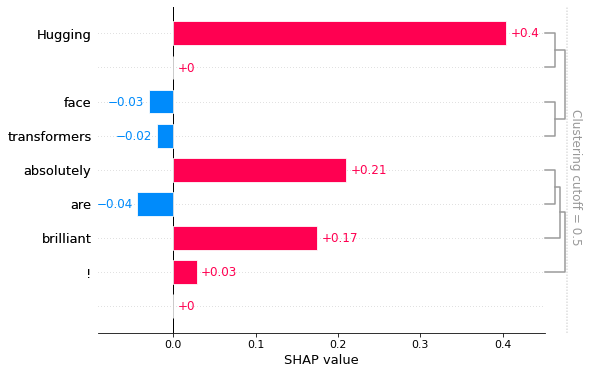

In [7]:
shap.plots.bar(shap_values[0,:,'POSITIVE'])

As we can clearly see, using the force plot and bar plots in SHAP, we can visualize the words which contributes positively and the words which contribute negatively towards the model prediction. Now, let's try out with a multi-class classification example using the Hugging Face transformers.

### Explaining Multi-Class prediction transformer models using SHAP

In [8]:
# Loading the hugging face model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion", use_fast=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

# build a pipeline object to do predictions
pipeline = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, return_all_scores=True)

In [9]:
# explaining using SHAP
explainer = shap.Explainer(pipeline)
shap_values = explainer([text_data])
shap.plots.text(shap_values[0])

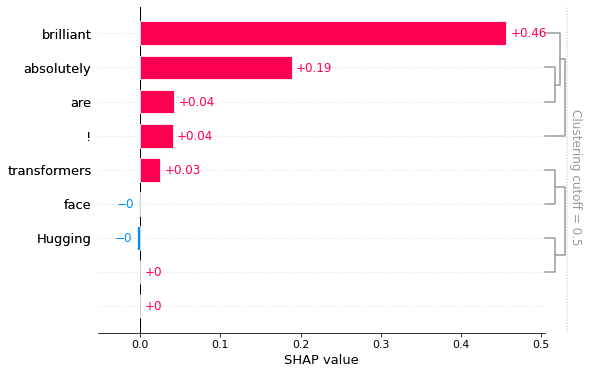

In [10]:
# Let's visualize the feature importance towards the outcome - joy
shap.plots.bar(shap_values[0,:,'joy'])

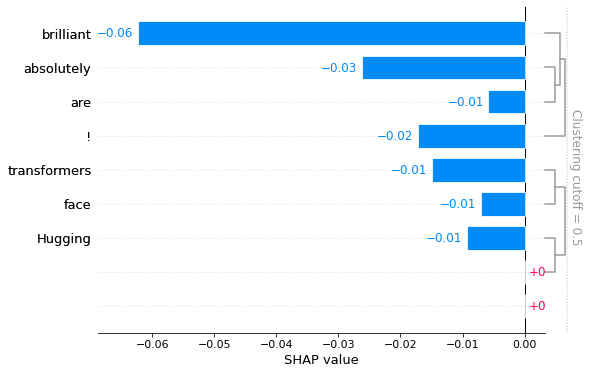

In [11]:
# Let's visualize the feature importance towards the outcome - sadness
shap.plots.bar(shap_values[0,:,'sadness'])

Now, we have applied SHAP to explain a pre-trained multi-class classification model from Hugging Face. The pre-trained model is used to detect the emotions - *sadness, joy, love, anger, fear, surprise* from text data. Using SHAP's force plot and bar plots, we can visualize the influence of each word present in the sentence towards the model's prediction. For the selected example - "*Hugging face transformers are absolutely brilliant!*", the words *brilliant* and *absolutely* contribute the most towards model's prediction as *joy*.

For the outcome *sadness*, we can see that almost all the words contribute negatively and this signifies that the outcome can never be *sadness*

Next, let us try out another very interesting concept used in NLP - Zero-Shot Learning. Zero-Shot Learning enables us to apply a trained model without fine-tuning on any labelled sample. Check out this: https://discuss.huggingface.co/t/new-pipeline-for-zero-shot-text-classification/681 to find out more on using Zero-Shot learning using hugging face transformers.

### Explaining Zero-Shot Learning using SHAP

In [12]:
# Loading the hugging face model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-3")
tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-3")

In [13]:
# Create a custom pipeline that only requires the text parameter 
# for the __call__ method and provides a method to set the labels
class ZeroShotModelPipeline(ZeroShotClassificationPipeline):
    # Overwrite the __call__ method
    def __call__(self, *args):
        out = super().__call__(args[0], self.set_labels)[0]

        return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])]]

    def set_labels(self, labels: Union[str,List[str]]):
        self.set_labels = labels

In [14]:
def score_and_visualize(text, shap_values):
    prediction = pipe(text)
    print(f"Model predictions are: {prediction}")
    shap.plots.text(shap_values)

In [15]:
text = ["I love playing cricket!"]
labels = ["insect","sports", "animal"]

In [16]:
# Assign the labels for the classification model
model.config.label2id.update({v:k for k,v in enumerate(labels)})
model.config.id2label.update({k:v for k,v in enumerate(labels)})

In [17]:
pipe = ZeroShotModelPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
pipe.set_labels(labels)

In [18]:
# SHAP Explainer
explainer = shap.Explainer(pipe)
shap_values = explainer(text)

  0%|          | 0/42 [00:00<?, ?it/s]

Partition explainer: 2it [00:14, 14.35s/it]                                                                  


In [19]:
score_and_visualize(text, shap_values)

Model predictions are: [[{'label': 'sports', 'score': 0.8340960144996643}, {'label': 'insect', 'score': 0.1633734405040741}, {'label': 'animal', 'score': 0.0025305617600679398}]]


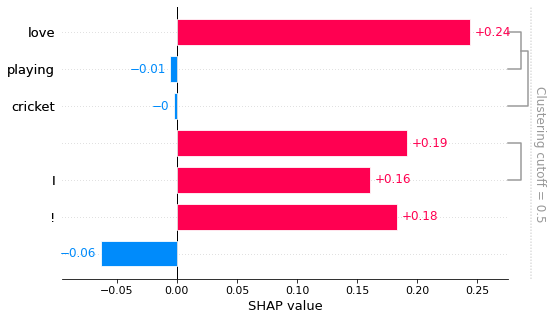

In [20]:
# Let's visualize the feature importance towards the outcome - sports
shap.plots.bar(shap_values[0,:,'sports'])

Hugging Face transformer framework, allows us to apply Zero-Shot learning in just few lines of code using pre-trained models without re-training or fine tuning on any labeled sample. Now, we have applied this model on a slightly difficult example. The example used is "I love playing cricket!". *Cricket* can be a sport or even it can an insect. So, ideally, the word cricket individually can contribute towards both the categories. But the term '*playing cricket*' definitely indicates the category sports. 

Although the model correctly predicted the category as sports, but when we used SHAP, we found out that the word *Cricket* has a negative contribution towards the model prediction. These are situations where model explainability is extremely crucial. Ideally speaking, the most important word that should contribute towards the correct prediction of the class sports, should have been *Cricket* and not *love*. This tells us that model is not robust enough and does have scope of improvement especially for the classes used for prediction.

## Final Thoughts

Transformers are indeed state of the model, especially for text data. Pre-trained transformer does make it easy to productionalize any intelligent system, without the hassle of training the algorithm from scratch. But explaining complicated models like Transformers can be really hard! In this tutorial, we have seen how easily SHAP can be used to explain transformer models from Hugging Face!

## Reference

1. Transformer Model - https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)
2. SHAP GitHub Project - https://github.com/slundberg/shap
3. SHAP Documentations - https://shap.readthedocs.io/en/latest/index.html
4. Hugging Face Transformer - https://github.com/huggingface/transformers
5. Hugging Face Zero-Shot Learning - https://discuss.huggingface.co/t/new-pipeline-for-zero-shot-text-classification/681
6. Zero-Shot Learning - https://towardsdatascience.com/zero-and-few-shot-learning-c08e145dc4ed
7. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073